In [1]:
%matplotlib inline
import pyspeckit
import numpy as np
from astropy import units as u
from astropy.io import fits
from astropy import constants as c
import matplotlib.pyplot as plt
from astropy.convolution import convolve, Box1DKernel
from c_normalize import c_normalize
import glob
import pandas as pd
import warnings
import mplcursors
pd.options.display.max_rows = 200
warnings.filterwarnings("ignore")
plt.style.use('seaborn-paper')

In [2]:
from contextlib import contextmanager
import sys, os

@contextmanager
def suppress_stdout():
    with open(os.devnull, "w") as devnull:
        old_stdout = sys.stdout
        sys.stdout = devnull
        try:  
            yield
        finally:
            sys.stdout = old_stdout

In [3]:
# Select Datasets and extract equivalent widths
spectrum = glob.glob("data/ew_known/tame_inputs/*wavsoln.fits")
by_hand = glob.glob("tame-1.1.0/*.ew")
lc_range = np.arange(0.95,0.995,0.0001)
len_range = 10


d = {'Spectrum File': spectrum, 'By-Hand File': by_hand}
disp_df = pd.DataFrame(data=d)

lines = pd.read_csv(by_hand[0], header=None, delim_whitespace=True)[0].tolist()

In [ ]:

width = 10 #Distance from the line on both sides to sample the local continuum from
gauss_amp = -0.2
gauss_width = 0.15
gauss_centhresh = 0.2

#pars_dict -- key: local continuum range (Angstroms), Sample Region Left, Sample Region Right, Gaussian Amplitude Estimates (in list for multicomponent fits), gaussian center offsets (in list for multicomponent fits), Gaussian Width, selected component
pars_dict={'5838.37':(10,0.15, 0.15,[-0.3],[0],0.15, 0), '7189.16':(10,0.3,0.1,[-0.3],[0],0.15, 0), '5712.13':(10,0.1,0.17,[-0.3],[0],0.15,0),
          '5698.02':(10,0.25,0.7, [-0.3,-0.5], [0,0.2], 0.15, 0), '5284.1':(10,1,0.4,[-0.3,-0.7,-0.3],[0, -0.3, 0.2],0.15, 0),
          '5536.58':(10,0.1,0.2, [-0.3],[0],0.15,0)}

survey = []
all_meas = []
for line in lines:
    # Set fitting parameters
    multicomponent=False
    if str(line) in pars_dict.keys():
        key = str(line)
        print(key)
        if len(pars_dict[key][3]) > 1:
            multicomponent=True 
        
        width = pars_dict[key][0] #Distance from the line on both sides to sample the local continuum from
        gauss_centhresh_l = pars_dict[key][1]
        gauss_centhresh_r = pars_dict[key][2]  
        gauss_amps = pars_dict[key][3] #list for components
        gauss_cenoffs = pars_dict[key][4] #list for components
        gauss_width = pars_dict[key][5]
        c_select = pars_dict[key][6]


    else:
        width = 10 #Distance from the line on both sides to sample the local continuum from
        gauss_amps = [-0.2]
        gauss_width = 0.15
        gauss_centhresh_l = 0.2
        gauss_centhresh_r = 0.2
        gauss_cenoffs = [0.0]
        c_select = 0

    percent_difference = True
    diff = []
    for row in disp_df.iterrows():
        eqw_file, spec_file = row[1]
        eqw_df = pd.read_csv(eqw_file, header=None, delim_whitespace = True)
        if line not in eqw_df[0].tolist():
            print("{} Line Missing: {}".format(spec_file,line))
            continue
        mask = eqw_df[0] == line
        byhand_eqw = eqw_df[4][mask.tolist()].tolist()[0]
        if byhand_eqw == 0.:
            continue
        s_hdu = fits.open(spec_file)
    
        # Grab the flux and wavelength arrays from the spectrum
        s_data = s_hdu[1].data
        s_flux = s_data['FLUX']
        #smoothed_flux = convolve(s_flux, Box1DKernel(5)) # Smooth the flux for more reliable continuum fitting
        #s_flux = smoothed_flux
        s_wav = s_data['WAVEL']

        # Specify up a specific line to measure the EQW for, and specify the wavelength range to sample for the local continuum
        lim_l = line - width
        lim_r = line + width

        # Mask the flux and wavelength arrays based on the sampled wavelength range
        wav_mask = (s_wav > lim_l) & (s_wav < lim_r)
        s_flux = s_flux[wav_mask]
        s_wav = s_wav[wav_mask]

        # Normalize the spectrum with the local continuum to 1.0, c_normalize returns the normalized spectrum in norm, but also the local continuum fit in yfit if desired
        yfit, norm, _ = c_normalize(s_flux, s_wav, median_replace=False, cheby=True, low_cut = 0.99)
        # Load the normalized spectrum into a pyspeckit.Spectrum object
        sp = pyspeckit.Spectrum(data=norm, xarr=s_wav * u.AA)

        #Get around pyspeckits reliance on a generated baseline and just generate basespec as a ones array (continuum is always one in normalized case)
        sp.baseline.basespec = np.ones(len(s_wav))
        

        #Fit a gaussian to the line, this may be too simplistic for blended lines
        guesses = []
        for amp,cenoff in zip(gauss_amps,gauss_cenoffs):
            guesses.append(amp)
            guesses.append(line+cenoff)
            guesses.append(gauss_width)
        #print(guesses)
            
        with suppress_stdout(): #Suppress some annoying info messages that don't translate well to automation
            sp.specfit(fittype='gaussian', guesses = guesses, exclude= [0,line-gauss_centhresh_l, line+gauss_centhresh_r, line+5000])
        fwhm = sp.specfit.parinfo[2].value

        #Measure the Equivalent Width of the gaussian line fit against the normalized baseline
        EQW = sp.specfit.EQW(plot=False, continuum_as_baseline=True, xmin = 0, xmax = len(norm),components=multicomponent)
        if multicomponent:
            EQW = EQW[c_select]*1000 #mA
        else:
            EQW = EQW * 1000 #mA
        all_meas.append([line, spec_file.split('/')[-1], ((EQW-byhand_eqw)/byhand_eqw) * 100,EQW-byhand_eqw, fwhm]) #append both formats to the all measurements df
        if percent_difference:
            ew_diff = ((EQW-byhand_eqw)/byhand_eqw) * 100 #Percent Difference
        else:
            ew_diff = EQW-byhand_eqw #mA Difference
        if ew_diff < 1000: #Try to cut out some of these crazy fits
            diff.append(ew_diff)
    if percent_difference:
        symbol = "%"
    else:
        symbol = " mA"
    line_stats = [line, np.median(diff),np.std(diff)]
    survey.append(line_stats)

survey_df = pd.DataFrame(survey, columns=["Line (Angstroms)", "Median Difference","Standard Deviation of Difference"])
all_meas_df = pd.DataFrame(all_meas, columns=["Line (Angstroms)", "Spectrum", "Difference (%)","Difference (mA)","FWHM"])

5536.58
5698.02


### Performance Against Known EQWs

In [85]:
print("Difference Type: ",symbol)
survey_df

Difference Type:  %


,Line (Angstroms),Median Difference,Standard Deviation of Difference
0,5536.58,16.877465,19.299085
1,5698.02,10.823300,13.312064
2,5712.13,19.784724,10.993379
3,5838.37,9.875501,8.572442
4,7189.16,2.667790,7.697678
5,5284.10,5.289055,8.831280


Difference Type:  %


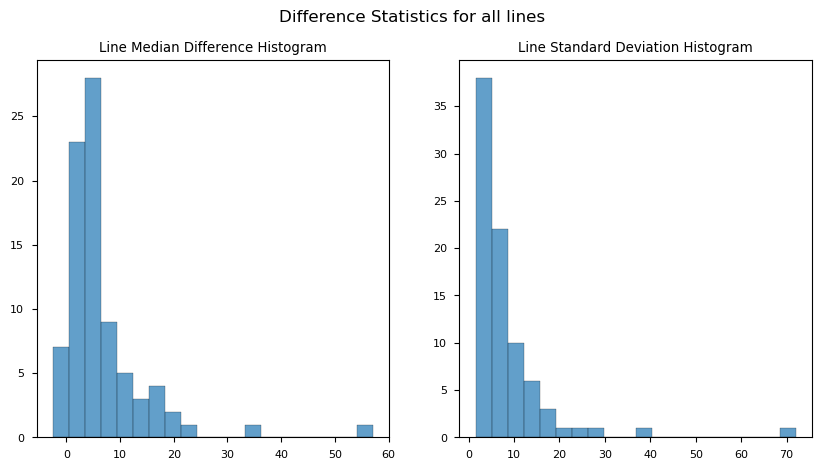

In [65]:
fig, axes = plt.subplots(1,2, figsize = (10,5), dpi = 100)
ax1,ax2 = axes
fig.suptitle("Difference Statistics for all lines")
ax1.hist(survey_df['Median Difference'],histtype='bar',ec='black',alpha=0.7,color = plt.cm.tab20(0),bins=20)
ax1.set_title("Line Median Difference Histogram")
ax2.hist(survey_df['Standard Deviation of Difference'], histtype='bar',ec='black',alpha=0.7,color = plt.cm.tab20(0),bins=20)
ax2.set_title("Line Standard Deviation Histogram")

print("Difference Type: ",symbol)

Difference Type:  %


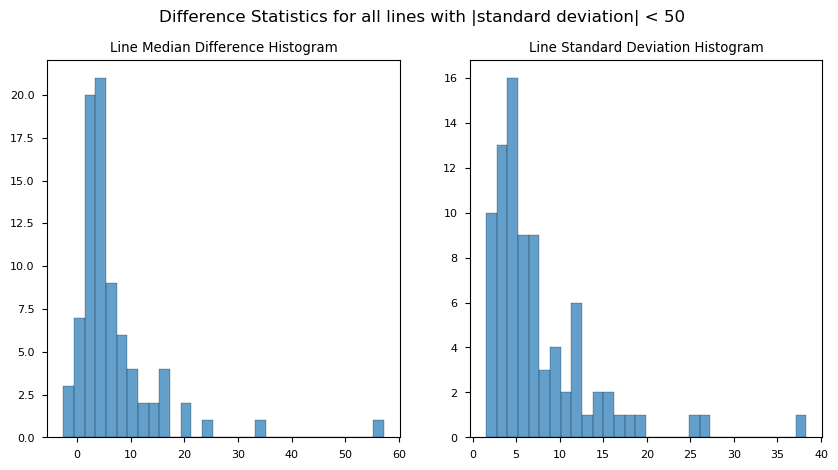

In [66]:
fig, axes = plt.subplots(1,2, figsize = (10,5), dpi = 100)
ax1,ax2 = axes
fig.suptitle("Difference Statistics for all lines with |standard deviation| < 50")
mask = abs(survey_df['Standard Deviation of Difference']) < 50
ax1.hist(survey_df['Median Difference'][mask],histtype='bar',ec='black',alpha=0.7,color = plt.cm.tab20(0),bins=30)
ax1.set_title("Line Median Difference Histogram")
ax2.hist(survey_df['Standard Deviation of Difference'][mask], histtype='bar',ec='black',alpha=0.7,color = plt.cm.tab20(0),bins=30)
ax2.set_title("Line Standard Deviation Histogram")

print("Difference Type: ",symbol)

### Equivalent Width Agreement compared to Broadening

In [87]:
percent_difference = False
if percent_difference:
    delta_eqw = all_meas_df['Difference (%)'] #percent diff
    symbol='%'
else:
    delta_eqw = all_meas_df['Difference (mA)'] #mA diff
    symbol="mA"
    
broadening = c.c.value*(all_meas_df['FWHM']/all_meas_df['Line (Angstroms)'])

import plotly.plotly as py
import plotly.graph_objs as go

data = [go.Scatter(mode='markers', x = delta_eqw,y = broadening,text = all_meas_df['Line (Angstroms)'],hoverinfo = 'text',marker = dict(color = 'rgba(17, 157, 255,0.5)',size = 10,line = dict(color = 'rgba(0, 0, 0,0.5)',width = 1)))]

layout = go.Layout(autosize=False,
    width=800,
    height=800,
    title="Equivalent Width Difference vs Line Broadening (N = {})".format(len(delta_eqw)),
    xaxis=dict(
        title=r"Equivalent Width Difference ({})".format(symbol),
        titlefont=dict(
            family='Courier New, monospace',
            size=18,
            color='#7f7f7f'
        )
    ),
    yaxis=dict(
        title=r"c*FWHM/lambda (km/s)",
        titlefont=dict(
            family='Courier New, monospace',
            size=18,
            color='#7f7f7f'
        )
    )
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename = "add-hover-text")

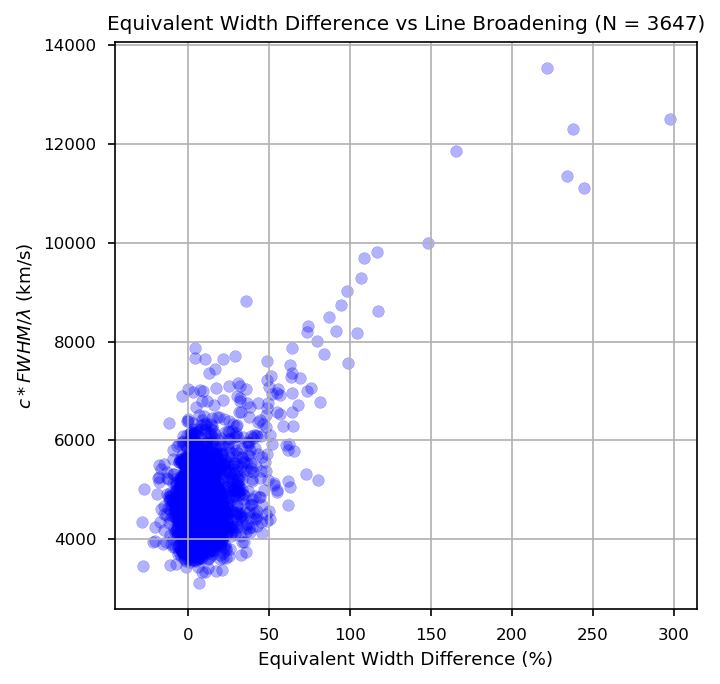

In [24]:
percent_difference = True
if percent_difference:
    delta_eqw = all_meas_df['Difference (%)'] #percent diff
    symbol='%'
else:
    delta_eqw = all_meas_df['Difference (mA)'] #mA diff
    symbol="mA"
    
broadening = c.c.value*(all_meas_df['FWHM']/all_meas_df['Line (Angstroms)'])

fig = plt.figure(figsize=(5,5), dpi=150)
#plt.plot(delta_eqw,broadening, '.', color = 'r', alpha=0.5)
plt.scatter(delta_eqw,broadening, alpha=0.3, color='b')
plt.title("Equivalent Width Difference vs Line Broadening (N = {})".format(len(delta_eqw)))
plt.xlabel("Equivalent Width Difference ({})".format(symbol))
plt.ylabel(r"$c*FWHM/\lambda$ (km/s)")
#plt.axvline(10,alpha = 0.4, color = 'k')
#plt.axvline(-10,alpha = 0.4, color = 'k')
plt.grid()


<class 'float'>
